<a href="https://colab.research.google.com/github/DrAlexSanz/Happy-house/blob/master/Smile_detector_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import h5py

from PIL import Image

from keras import layers, optimizers
from keras.layers import Input, Dense, Conv2D, Activation, ZeroPadding2D, BatchNormalization, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.models import Model, Sequential

from keras.preprocessing import image

from keras.utils import layer_utils, plot_model

from keras.callbacks import History

keras.backend.set_image_data_format('channels_last')

%matplotlib inline

print("Everything imported correctly")

Everything imported correctly


Load the data, kill the previous files and clone github repo.

In [51]:
#First remove the folder and everything it contains.

!rm -rf Happy-house

#Now I clone the repository and everything works.

! git clone https://github.com/DrAlexSanz/Happy-house.git

Cloning into 'Happy-house'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


Now read data.



In [52]:
#Now read data

with h5py.File("Happy-house/test_happy.h5") as test:
  test_x_1 = np.array(test["test_set_x"][:]) # your train set features
  test_y_1 = np.array(test["test_set_y"][:]) # your train set labels
  classes = np.array(test["list_classes"][:]) # the list of classes

with h5py.File("Happy-house/train_happy.h5") as train:
  train_x_1 = np.array(train["train_set_x"][:]) # train set features
  train_y_1 = np.array(train["train_set_y"][:]) # train set labels

print("Everything loaded and imported")

Everything loaded and imported


Load one picture to check.

y = 1


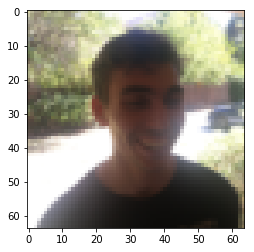

In [53]:
plt.imshow(train_x_1[13])
print("y = " + str(train_y_1[13]))

In [0]:
#Normalize

train_x = train_x_1/255
test_x = test_x_1/255

train_y = train_y_1
test_y = test_y_1

y = 1


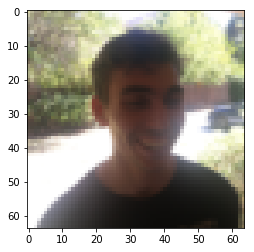

In [55]:
plt.imshow(train_x[13])
print("y = " + str(train_y[13]))

Just for this time, after normalizing I won't see any difference in my picture. It's only a change of scale.

In [56]:
print("X train shape is: " + str(train_x.shape))
print("Y train shape is: " + str(train_y.shape))
print("X test shape is: " + str(test_x.shape))
print("Y test shape is: " + str(test_y.shape))

X train shape is: (600, 64, 64, 3)
Y train shape is: (600,)
X test shape is: (150, 64, 64, 3)
Y test shape is: (150,)


So I have 600 (+ 150 test) pictures of 64x64 in 3 colours.

Now I will create a model in Keras that fits/predicts if the picture is "smily". The topology of the network is:



1.   CONV, RELU, BatchNorm (x2)
2.   Fully connected with a sigmoid because I predict 0 or 1 (1 layer, to be changed later).

Batch norm is a way to isolate the layers from each other. This way, layer 3 does not affect layer 356 (for example) too much. If not used, this may cause exploding or vanishing gradients. This can be seen as in the chain rule, layer 1 depends on all the previous (following) layers. With a batch norm I decouple the system. There's a video by Ian Goodfellow and another by Andrew Ng, very good.



In [0]:
def happy_model(Input_Shape):
  """
  The function implements the model for the happy house. Note that in TF I had the placeholders and all the X -> Z -> A
  Here I use X to overwrite the values. This is how Keras works.
  
  Input is the shape of the images
  
  Output is the model() instance
  """
  
  batch = 32
  filters_1 = 32
  size_filter = 3
  dropout_prob = 0
  
  x_input = Input_Shape
  
  model = Sequential()
  
  #First conv, relu, BN
  
  model.add(Conv2D(batch, kernel_size = (size_filter, size_filter), padding = "same", strides = (3, 3), input_shape = (x_input, x_input, 3)))
            
  model.add(Activation("relu"))
            
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(2,2)))
            
  #First conv, relu, BN
  
  model.add(Conv2D(batch, kernel_size = (size_filter, size_filter), padding = "same", strides = (5, 5), input_shape = (x_input, x_input, 3)))
            
  model.add(Activation("relu"))
            
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(2,2)))
            
  #Flatten and FC layer
            
  model.add(Flatten())
  
  model.add(Dense(1, activation = "sigmoid"))
          
  return model
  
  

Now I have to create the model. Then I can train it and use it to predict.

In [58]:
happy = happy_model(train_x.shape[1])

# happy = happy_model(64)

happy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 22, 22, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
activation_4 (Activation)    (None, 3, 3, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 32)          128       
__________

So far it doesn't complain. Let's compile it.

In [0]:
opti = optimizers.Adam(lr = 1e-3)

happy.compile(loss = "binary_crossentropy", optimizer = opti, metrics = ["accuracy"])
hist = History()

In [60]:
num_epochs = 50

happy.fit(train_x, train_y, batch_size = 128, epochs = num_epochs, validation_data = (test_x, test_y), shuffle = True, callbacks = [hist])

Train on 600 samples, validate on 150 samples
Epoch 1/50
600/600 [==============================] - 1s 1ms/step - loss: 0.6967 - acc: 0.5983 - val_loss: 0.6806 - val_acc: 0.6333
Epoch 2/50
600/600 [==============================] - 0s 175us/step - loss: 0.4936 - acc: 0.7600 - val_loss: 0.6417 - val_acc: 0.6533
Epoch 3/50
600/600 [==============================] - 0s 174us/step - loss: 0.4031 - acc: 0.8467 - val_loss: 0.5193 - val_acc: 0.7467
Epoch 4/50
600/600 [==============================] - 0s 180us/step - loss: 0.3451 - acc: 0.8700 - val_loss: 0.4646 - val_acc: 0.7933
Epoch 5/50
600/600 [==============================] - 0s 168us/step - loss: 0.3047 - acc: 0.8883 - val_loss: 0.4280 - val_acc: 0.8000
Epoch 6/50
600/600 [==============================] - 0s 174us/step - loss: 0.2816 - acc: 0.8967 - val_loss: 0.4490 - val_acc: 0.7400
Epoch 7/50
600/600 [==============================] - 0s 185us/step - loss: 0.2260 - acc: 0.9367 - val_loss: 0.3670 - val_acc: 0.8600
Epoch 8/50
600/600

And it trains ok. It's a super simple network so it goes fast. I'll do a more complicated one later. It may not be necessary but it's good to play with all the parameters.

In [61]:
pred = happy.evaluate(test_x, test_y)

print("Loss is: " + str(pred[0]))
print("Accuracy is: " + str(pred[1]))

150/150 [==============================] - 0s 202us/step
Loss is: 0.16652068237463633
Accuracy is: 0.9533333309491475


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


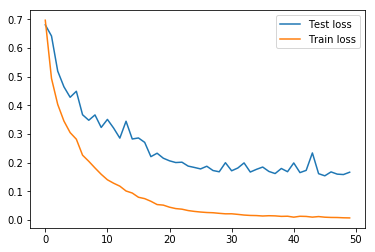

In [62]:
print(hist.history.keys())

plt.figure();

plt.plot(range(num_epochs), list(hist.history.values())[0], label = "Test loss");
plt.plot(range(num_epochs), list(hist.history.values())[2], label = "Train loss");
plt.legend(loc = "best")

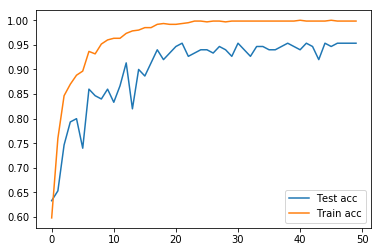

In [63]:
plt.figure();

plt.plot(range(num_epochs), list(hist.history.values())[1], label = "Test acc");
plt.plot(range(num_epochs), list(hist.history.values())[3], label = "Train acc");
plt.legend(loc = "best")

Now let's see if the model predicts correctly, with just a few pictures.

I would normally put this whole process into one or two functions but here I won't do it. It's just to try it so I will probably work more unnecesarily.

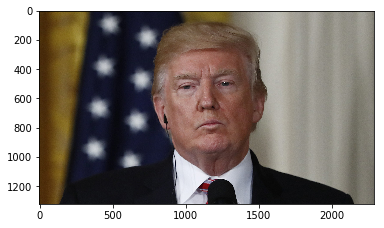

In [64]:
#Serious image. Let's see. First load, then resize to 64x64 and then predict.
ser = Image.open("Happy-house/serious.jpg")
plt.imshow(ser)

Original size is:  (2290, 1322)
New size is:  (64, 64)


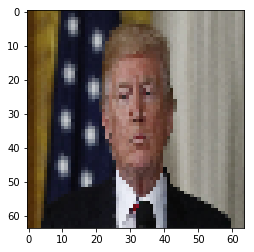

In [65]:
#Resize to 64 x 64

print("Original size is: ", ser.size)

ser_res = ser.resize((64, 64))

print("New size is: ", ser_res.size)

ser_res = np.asarray(ser_res) #So far it was an image and I want an array
ser_res = ser_res/255 # It was all normalized before

plt.imshow(ser_res)

Now predict.

In [66]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

ser_res = np.expand_dims(ser_res, axis=0)

pred_serious = happy.predict(ser_res)
prob_ser = pred_serious

pred_serious = np.argmax(np.round(pred_serious))

print("The class is: ", pred_serious)

The class is:  0


So the model predicted 99.5% probability of class 0. Checking the train/test dataset it's correct. Now let's do the same thing with the smiling picture.

RGBA


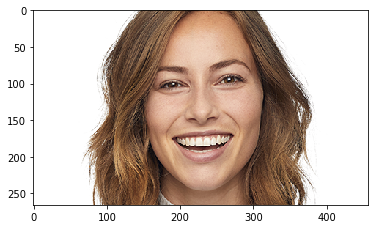

In [67]:
#Smile image. Let's see. First load, then resize to 64x64 and then predict.
smi = Image.open("Happy-house/smile.png")
plt.imshow(smi)
print(smi.mode)

I just noticed that the image is RGBA, not RGB. I didn't know that mode existed. Anyway, convert it. In the future I can check it at testing or preprocessing time with an if, for example.

Original size is:  (457, 266)
New size is:  (64, 64)


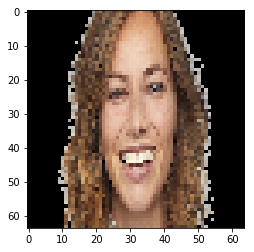

In [68]:
#Resize to 64 x 64
smi = smi.convert("RGB")

print("Original size is: ", smi.size)

smi_res = smi.resize((64, 64))

print("New size is: ", smi_res.size)

smi_res = np.asarray(smi_res) #So far it was an image and I want an array
smi_res = smi_res/255 # It was all normalized before

plt.imshow(smi_res)

Notice the conversion leaves a black background. Let's see how this works with the predictions.

In [69]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

smi_res = np.expand_dims(smi_res, axis=0)

pred_smi = happy.predict(smi_res)
prob_smi = pred_smi

pred_smi = np.argmax(np.round(pred_smi))

print("The probability is: ", prob_smi)
print("The class is: ", pred_smi)

The probability is:  [[0.6952774]]
The class is:  0


INCORRECT!! And low probability. This is probably due to the conversion. Let's try two more.

RGB


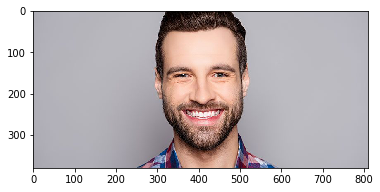

In [71]:
#Smile image. Let's see. First load, then resize to 64x64 and then predict.
smi2 = Image.open("Happy-house/smiling2.jpg")
plt.imshow(smi2)
print(smi2.mode)

Original size is:  (810, 380)
New size is:  12288


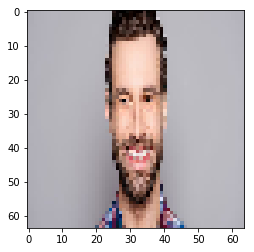

In [72]:
#Resize to 64 x 64

print("Original size is: ", smi2.size)

smi2_res = smi2.resize((64, 64))

print("New size is: ", smi_res.size)

smi2_res = np.asarray(smi2_res) #So far it was an image and I want an array
smi2_res = smi2_res/255 # It was all normalized before

plt.imshow(smi2_res)

In [73]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

smi2_res = np.expand_dims(smi2_res, axis=0)

pred_smi2 = happy.predict(smi2_res)
prob_smi2 = pred_smi2

pred_smi2 = np.argmax(np.round(pred_smi2))

print("The probability is: ", prob_smi2)
print("The class is: ", pred_smi2)

The probability is:  [[0.9983854]]
The class is:  0


RGB


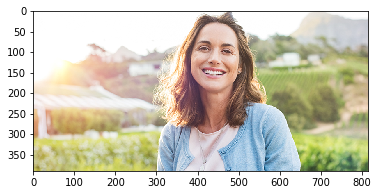

In [74]:
#Smile image. Let's see. First load, then resize to 64x64 and then predict.
smi2 = Image.open("Happy-house/smilingispowerful.jpg")
plt.imshow(smi2)
print(smi2.mode)

Original size is:  (816, 390)
New size is:  12288


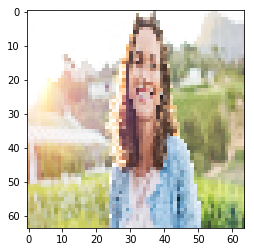

In [75]:
#Resize to 64 x 64

print("Original size is: ", smi2.size)

smi2_res = smi2.resize((64, 64))

print("New size is: ", smi_res.size)

smi2_res = np.asarray(smi2_res) #So far it was an image and I want an array
smi2_res = smi2_res/255 # It was all normalized before

plt.imshow(smi2_res)

In [76]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

smi2_res = np.expand_dims(smi2_res, axis=0)

pred_smi2 = happy.predict(smi2_res)
prob_smi2 = pred_smi2

pred_smi2 = np.argmax(np.round(pred_smi2))

print("The probability is: ", prob_smi2)
print("The class is: ", pred_smi2)

The probability is:  [[0.12338302]]
The class is:  0


Somehow this model doesn't predict smiling people too well. I will try to tune the model a bit and change the dimensions of the layers and then re run the whole thing. Interesting.